In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import os,sys
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

In [2]:
all_ssm_npzs = glob.glob('/net/scratch/aditya20/af2exp/ssm_initaf2_training/*.npz')
print(f'Number of training examples {len(all_ssm_npzs)}')
import random as rn
rn.shuffle(all_ssm_npzs)
test_ssm_npzs = all_ssm_npzs[:1000]

Number of training examples 4168


In [3]:
home_path = '/home/aditya20/experimentsWaf2'
scratch_path = '/net/scratch/aditya20/af2exp'
score_labels = {}
with open(f'{home_path}/valid_binder_data.sc') as f:
    for line in f:
        words = line.strip().split()
        pdb = words[0]
        beneficial = words[1]
        neutral = words[3]
        
        if beneficial == 'True' or neutral == 'True':
            score_labels[pdb] = 1
        else:
            score_labels[pdb] = 0

In [4]:
import jax.numpy as jnp
import jax
def _jnp_softmax(x, axis=-1):
    unnormalized = jnp.exp(x - jax.lax.stop_gradient(x.max(axis, keepdims=True)))
    return unnormalized / unnormalized.sum(axis, keepdims=True)

In [5]:
arrays_list = []
labels = []

for file in all_ssm_npzs:
    try:
        npzfile = np.load(file,allow_pickle=True)
        mask = npzfile['arr_0'].item()['peptide_mask']
        L1 = np.count_nonzero(mask)

        pae = npzfile['arr_0'].item()['predicted_aligned_error']
        pae_logits = npzfile['arr_0'].item()['pae_logits']
        pae_inter = 0.5*(pae[:L1,L1:].mean()+pae[L1:,:L1].mean())

        Ca_mask = npzfile['arr_0'].item()['structure_module']['final_atom_mask'][:,1]
        Ca_mask_2D = Ca_mask[:,None]*Ca_mask[None,:]
        #Ca_mask_2D = np.expand_dims(Ca_mask_2D, axis=-1)

        mask_2D = (mask[:,None])*(1-mask[None,:])
        mask_2D_symm = mask_2D + mask_2D.T

        pae_probs = _jnp_softmax(pae_logits)

        #print(Ca_mask_2D.shape, mask_2D_symm.shape)
        '''
        pae_probs_new = np.zeros((300,300,64))
        pae_probs_new[:pae_probs.shape[0],:pae_probs.shape[1]] = pae_probs

        Ca_mask_new = np.zeros((300,300,1))
        Ca_mask_new[:Ca_mask_2D.shape[0],:Ca_mask_2D.shape[1]] = Ca_mask_2D

        mask_new = np.zeros((300,300))
        mask_new[:mask_2D_symm.shape[0],:mask_2D_symm.shape[1]] = mask_2D_symm

        '''

        pae_new = jnp.sum(Ca_mask_2D[:,:,None]*mask_2D_symm[:,:,None]*pae_probs, (-2, -3))/jnp.sum(Ca_mask_2D * mask_2D_symm)
        #print(pae_new.shape)
        arrays_list.append(pae_new)
        pdb = file.split('tmp_')[1].split('__pred')[0]
        labels.append(score_labels[pdb])
    except:
        continue
        
label_inputs = np.array(labels)   
pae_inputs = np.stack(arrays_list)
np.savez('ssm_inputs.npz',pae=pae_inputs,label=labels)

In [6]:
print(f'PAE {pae_inputs.shape} label {label_inputs.shape}')

PAE (4166, 64) label (4166,)


In [7]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
ssmset = dataset(pae_inputs,label_inputs)
trainloader1 = DataLoader(ssmset,batch_size=128,shuffle=True)

In [8]:
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [9]:
learning_rate = 0.001
epochs = 2000
model = Net(input_shape=pae_inputs.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [ ]:
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader1):
    

    output = model(x_train)

    loss = loss_fn(output,y_train.reshape(-1,1))

    predicted = model(torch.tensor(pae_inputs,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == label_inputs).mean()
    
    losses.append(loss)
    accur.append(acc)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%200 == 0:
    tmp1 = [i.detach().numpy() for i in losses]

    print("epoch {}\tloss : {}\t accuracy : {}".format(i,np.mean(tmp1),np.mean(accur)))
    losses = []
    accur = []

epoch 0	loss : 0.5900837182998657	 accuracy : 0.6907068767366414
epoch 200	loss : 0.5865978598594666	 accuracy : 0.693133337697668
epoch 400	loss : 0.5830234289169312	 accuracy : 0.69591054568731
epoch 600	loss : 0.580041229724884	 accuracy : 0.6976203101587163
epoch 800	loss : 0.5762271285057068	 accuracy : 0.69957105864211
epoch 1000	loss : 0.5741972327232361	 accuracy : 0.700551142728291
epoch 1200	loss : 0.5715715885162354	 accuracy : 0.7021003360537686
epoch 1400	loss : 0.5701290369033813	 accuracy : 0.7035404210128166


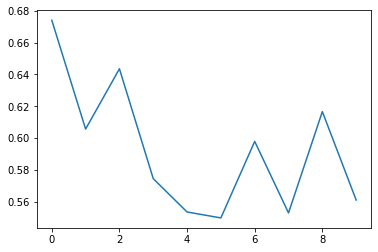

In [11]:
new = [i.detach().numpy() for i in losses]
plt.plot(new)